In [1]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.transforms import Compose, ToTensor, Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import random
import os

In [2]:
# 파라미터
CFG = {
    'IMG_SIZE':256,
    'EPOCHS':5,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':16,
    'SEED':41
}

In [3]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [4]:
path_list = sorted(glob.glob("PDA_mask_img/20X/**/*.png"))
path_list[:10]

['PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12691,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12691,w=518,h=518].png']

In [5]:
mask_path = path_list[0::2]
mask_path[:10]

['PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12691,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13144,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13598,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14051,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14504,w=518,h=518]-labelled.png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=7705,w=518,h=518]-labelled.png']

In [6]:
img_path = path_list[1::2]
img_path[:10]

['PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10425,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=10878,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=11785,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12238,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=12691,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13144,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=13598,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14051,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=14504,w=518,h=518].png',
 'PDA_mask_img/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10425,y=7705,w=518,h=518].png']

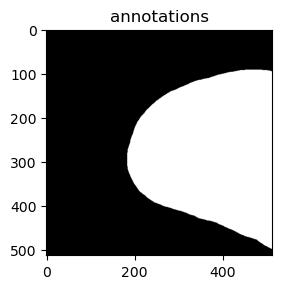

In [7]:
annotation = Image.open(mask_path[2])
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

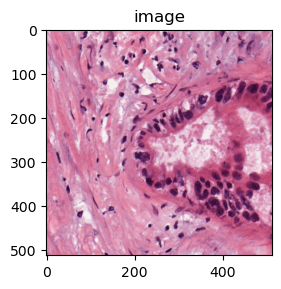

In [8]:
image = Image.open(img_path[2])
plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)


In [9]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, train = True, transforms = None):
        self.images = img_path
        self.annotations = mask_path
        
        # 학습용 or 평가용
        self.X_train = self.images[:int(0.8 * len(self.images))]
        self.X_test = self.images[int(0.8 * len(self.images)):]

        self.Y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.Y_test = self.annotations[int(0.8 * len(self.annotations)):]

        self.train = train
        self.transforms = transforms

    def __len__(self):
        if self.train:
            return len(self.X_train) # 학습용 데이터셋 길이
        else:
            return len(self.X_test) # 평가용 데이터셋 길이
        
    
    def __getitem__(self, i):
        if self.train:  # 학습용 데이터
            X_train = Image.open(self.X_train[i])
            X_train = self.transforms(X_train)
            Y_train = Image.open(self.Y_train[i])
            Y_train = self.transforms(Y_train)

            return X_train, Y_train
        
        else:  # 평가용 데이터
            X_test = Image.open(self.X_test[i])
            X_test = self.transforms(X_test)
            Y_test = Image.open(self.Y_test[i])
            Y_test = self.transforms(Y_test)

            return X_test, Y_test

In [10]:
# U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # U-Net의 인코더에 사용되는 은닉층
        # 기본 블록
        self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)

        # 디코더에 사용되는 은닉층
        self.upsample4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride = 2)
        self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding = 1)
        self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding = 1)

        self.upsample3 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride = 2)
        self.dec3_1 = nn.Conv2d(512, 256, kernel_size = 3, padding = 1)
        self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride = 2)
        self.dec2_1 = nn.Conv2d(256, 128, kernel_size = 3, padding = 1)
        self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride = 2)
        self.dec1_1 = nn.Conv2d(128, 64, kernel_size = 3, padding = 1)
        self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)

        # 합성곱과 업샘플링층의 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1)

        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2)

        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3)

        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool4(e4)

        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x)
        x = self.relu(x)
        
        x = self.upsample4(x)
        # 인코더의 출력과 업샘플링된 이미지를 합침
        x = torch.cat([x, e4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)

        x = self.upsample3(x)
        x = torch.cat([x, e3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)

        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)

        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)

        x = torch.squeeze(x)

        return x

## 데이터 불러오기

In [11]:
'''
device = "cuda" if torch.cuda.is_available() else "cpu"
device
'''

'\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\ndevice\n'

In [12]:
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")

현재 디바이스는 mps:0 입니다.


In [13]:
transform = Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                    ToTensor()])

In [14]:
# 학습용 데이터
train_set = CustomDataset(img_path = img_path,
                 mask_path = mask_path,
                 transforms = transform)

# 평가용 데이터
test_set = CustomDataset(img_path = img_path,
                mask_path=mask_path,
                transforms=transform,
                train=False)

train_loader = DataLoader(train_set, batch_size = CFG["BATCH_SIZE"], shuffle = True)
test_loader = DataLoader(test_set)

In [15]:
print(len(train_set),len(test_set))

752 189


In [16]:
print(len(train_loader),len(test_loader))

47 189


## 학습

In [17]:
model = UNet().to(device)

optimizer = Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

In [49]:
for epoch in range(CFG["EPOCHS"]):

    for data, label in tqdm(train_loader):
        optimizer.zero_grad()
        preds = model(data.to(device))
        
        label = torch.squeeze(label)
        loss = nn.BCEWithLogitsLoss()(preds, label.type(torch.FloatTensor).to(device))
        loss.backward()
        optimizer.step()
    print(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "./UNet.pth")

  0%|          | 0/47 [00:00<?, ?it/s]

KeyboardInterrupt: 

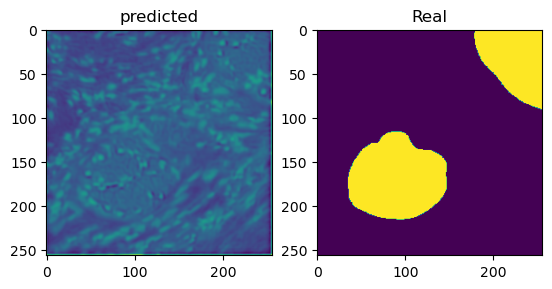

In [43]:
model.load_state_dict(torch.load("./UNet.pth", map_location="cpu"))
data, label = test_set[11]
pred = model(torch.unsqueeze(data, dim=0).to(device))
pred = pred.to("cpu")
label = torch.squeeze(label)
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.title("predicted")
    plt.imshow(pred)
    plt.subplot(1,2,2)
    plt.title("Real")
    plt.imshow(label)
    plt.show()

In [44]:
pred

tensor([[-2.8172, -4.2136, -4.8525,  ..., -5.2528, -4.4299, -2.9654],
        [-3.7970, -5.7252, -6.3753,  ..., -7.1159, -6.1230, -4.2652],
        [-4.0207, -5.7914, -6.5356,  ..., -7.7992, -6.8004, -4.8667],
        ...,
        [-4.7826, -6.8281, -7.4975,  ..., -8.3676, -7.5130, -5.4043],
        [-4.1985, -5.9254, -6.6530,  ..., -7.4393, -6.6579, -4.8211],
        [-2.5616, -3.9094, -4.4873,  ..., -5.1475, -4.6624, -3.2257]],
       grad_fn=<ToCopyBackward0>)